In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'email-classification-ham-spam:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4812840%2F8140416%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240629%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240629T163822Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D70c7f0b9d8362654cdac5138254bbd3497bb6cf44869fe17511ff18d3cdfe9068351dc1f6165141d5d1bd9e7732d3e9b61b7e439813cb7cceb32515ccda9822058ae2f3f116b8f00b35f89a3b4ee81c5f6ec4d9247b196fb654a8c2b083c6c66df67e6d52ff1820e9f92c32423933b6cfc84f0c60079576d80eab3cc5dbbad64ee7fb4855fb1be1eda6a106c552f29ab75fd1cc550f18d78260c42e94c7f527ec3f2db9dbb2df245673cb7ceb2f3bf8552d61d9f2d700dccc8ff14e7aa74ae9c7564c32a7e4e4d42c7389e3b3f06d4b3ebcd7b7b33708bbc39cd3eb1a39f3fc0064362789d365974298c13360e360af3cb85899a37c79f13ff3c5f38448f4a35'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4287 bytes downloaded
Downloaded and uncompressed: email-classification-ham-spam
Data source import complete.


In [2]:
# Imports
import pandas as pd
!pip install nltk
import nltk
from nltk.stem import PorterStemmer
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix, classification_report
from yellowbrick.classifier import ClassificationReport

In [3]:
# Data retrieval
data=pd.read_csv("/kaggle/input/email-classification-ham-spam/email_classification.csv")
data.head()

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


In [4]:
# Checking for any missing entries
data.isnull().sum()

email    0
label    0
dtype: int64

In [5]:
# Replace missing data with null string, which here are considered as spam
if data.isnull().sum().email:
    data=data.where((pd.notnull(data)),'')

In [6]:
# Ham=1, Spam=1
X=data['email']
y=data['label'].apply(lambda x: 1 if x =='ham' else 0)

In [7]:
# Test-train dataset split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
# Preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
ps = PorterStemmer()
def preProcess(text):
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in nltk.corpus.stopwords.words("english")]
    text = [nltk.WordNetLemmatizer().lemmatize(word) for word in text]
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
# Vectorization(TF-IDF)

tfidf_vect = TfidfVectorizer(analyzer=preProcess)

tfidf_train = tfidf_vect.fit_transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)

X_train_vect = pd.DataFrame(tfidf_train.toarray())
X_test_vect = pd.DataFrame(tfidf_test.toarray())

y_train = y_train.astype('int')
y_test = y_test.astype('int')

X_train_vect

,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.321702,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.219553,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.181699,0.000000
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.247190,0.000000
3,0.0,0.000000,0.000000,0.0,0.0,0.391244,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.303374
4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.229727,0.000000
139,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333359,0.132582,0.000000
140,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
141,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.332343


Precision: 1.0 / Recall: 1.0 / F1-Score: 1.0 / Accuracy: 100.0%


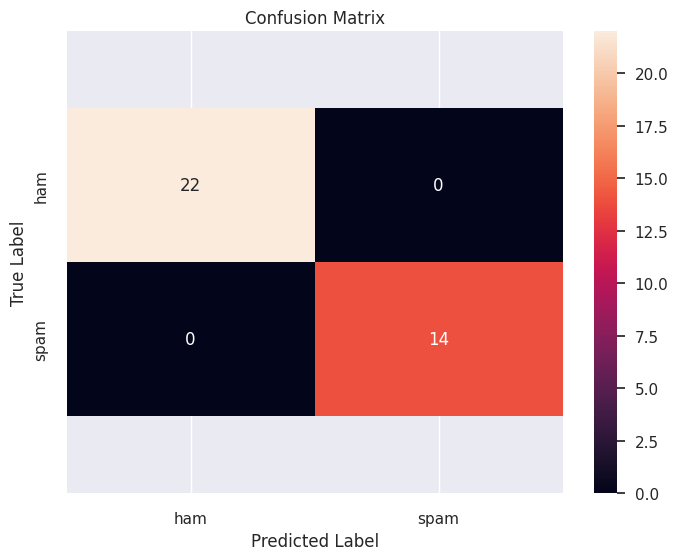

a


In [10]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train_vect, y_train)

y_pred = rf_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=0, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}%'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred)*100, 3)))

sns.set(rc= {"figure.figsize": (8, 6)})

cm = confusion_matrix(y_test, y_pred)
class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print('a')